# Sentiment Analysis of Twitter Posts
<!-- Notebook name goes here -->
<center><b>Notebook: Multinomial Logistic Regression, Error Analysis, and Tuning</b></center>
<br>

**By**: Stephen Borja, Justin Ching, Erin Chua, and Zhean Ganituen.

**Dataset**: Hussein, S. (2021). Twitter Sentiments Dataset [Dataset]. Mendeley. https://doi.org/10.17632/Z9ZW7NT5H2.1

**Motivation**: Every minute, social media users generate a large influx of textual data on live events. Performing sentiment analysis on this data provides a real-time view of public perception, enabling quick insights into the general population’s opinions and reactions.

**Goal**: By the end of the project, our goal is to create and compare supervised learning algorithms for sentiment analysis.

# **1. Project Set-up**



In [118]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score,
    GridSearchCV,
    StratifiedKFold
)
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    log_loss,
    make_scorer, 
    brier_score_loss
)
from sklearn.pipeline import Pipeline

sys.path.append(os.path.abspath("../lib"))
from anal_ysis_tools import (
    report_classification_performance,
    report_unseen_test_words,
    report_misleading_words_by_lift,
)

# **2. Data Set-up**

In [119]:
import IPython.core.page
import builtins
from IPython.utils.capture import capture_output

pager = IPython.core.page.page
helper = builtins.help

IPython.core.page.page = lambda *args, **kwargs: None
builtins.help = lambda *args, **kwargs: None

try:
    with capture_output():
        %run data.ipynb
finally:
    IPython.core.page.page = pager
    builtins.help = helper

print("Data Setup is DONE")

# Tests
assert X.shape == (162_801, 29318), "Feature matrix shape is wrong; expected (162_801, 29318)"
assert y.shape == (162_801,), "Labels shape is wrong; expected (162_801,)"

assert X_train.shape == (113_960, 29_318), "Train shape is wrong; expected (113_960, 2)"
assert X_test.shape == (48_841, 29_318), "Test shape is wrong; expected (48_841, 2)"

assert y_train.shape == (113_960,), "Train labels shape is wrong; expected (113_960,)"
assert y_test.shape == (48_841,), "Test labels shape is wrong; expected (48_841,)"
print("All tests passed.")

Data Setup is DONE
All tests passed.


# **3. Model Selection**

**Multinomial Logistic Regression (MLR)**, also known as Softmax Regression, was selected as our second statistical model with **Multinomial Naive Bayes (MNB)** acting as the baseline. Compared to **MNB**, **MLR** is a distcriminative model more suited for higher accuracy and probablistic estimates of multi-class problems, it is known to be efficient in handling large-scale text analysis due to its speed, scalability, and ability to handle linearly separable data. 

# **4. Training the Model**

At the start of the modeling phase, we train a baseline model to establish a reference point for performance. The purpose of this baseline is not to achieve optimal results, but to provide a simple and reproducible benchmark against which future improvements can be evaluated.

## **Baseline Model**

Using the default parameters provided by sklearn

In [120]:
model = LogisticRegression()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_true = y_test

C:\Users\Erin\Documents\GITHUB\STINTSY-Order-of-Erin\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Initial Evaluation

Now that we have trained the baseline lets look at the results.

In [121]:
report_classification_performance(model, y_pred, y_true, show_cm=False, digits=4)

Accuracy: 0.843369300382875

Classification Report:

              precision    recall  f1-score   support

          -1     0.8142    0.7512    0.7814     10743
           0     0.8236    0.9004    0.8603     16542
           1     0.8744    0.8455    0.8597     21556

    accuracy                         0.8434     48841
   macro avg     0.8374    0.8324    0.8338     48841
weighted avg     0.8440    0.8434    0.8427     48841



array([ 0,  0,  0, ..., -1, -1,  0], shape=(48841,))

In [122]:
y_prob = model.predict_proba(X_test)
print(f"{log_loss(y_true, y_prob):.4f}")

0.4793


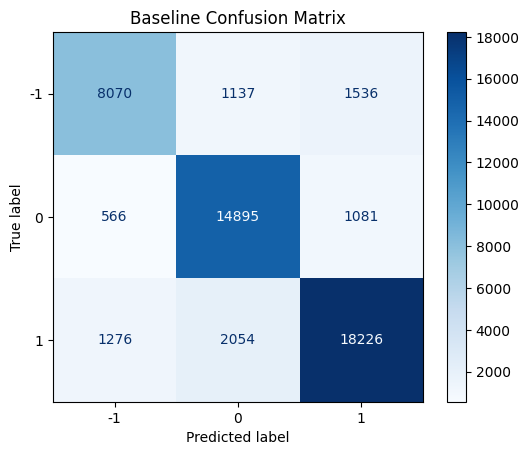

In [123]:
cm_baseline_values = confusion_matrix(y_true, y_pred)
cm_baseline = ConfusionMatrixDisplay.from_predictions(
    y_true, 
    y_pred,
    cmap='Blues',
    display_labels=[-1, 0, 1]
)
plt.title('Baseline Confusion Matrix')
plt.show()

The initial accuracy of the baseline model is at 84.33%. There is some consistency with the performance range between classes.

- Just like **MNB** the model struggled the most with the negative classifier -1 but with significantly increased performance
- Neutral classifier 0 has fairly high recall with lower precision, indicating higher identification of true positives
- While positive classifier 1 had a fairly balanced precision and recall score

The performance metrics align with the imbalance of the dataset, where negative classifiers perform relatively poorly due to it being a minority of the dataset

#### GridSearchCV

We start off by assessing the best possible current parameters for the model using GridSearchCV by changing the values of our `C`, `class_weight`, and `max_iter`.

- Values of `0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.8, 1` will be used as options for the our regularization weights `C`
- Options of `None, 'balanced'` are provided for the `class_weight` to automatically adjust weights inversely proportional to class frequencies in the input data
- Lastly, `max_iter` choices of `500, 1000, 2000` are provided to determine the maximum number of iterations for optimization algorithm (solvers) to converge

In [124]:
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.8, 1],
    'class_weight': [None, 'balanced'],
    'max_iter': [500, 1000, 2000],
}

In [125]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=kf, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV accuracy: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'C': 0.3, 'class_weight': None, 'max_iter': 500}
Best CV accuracy: 0.8450


## **Evaluation**

Based on the results of our GridSearchCV, the best parameters were 
- C: 0.3
- class_weight: None
- max_iter: 500

There is an slight increase in accuracy with the cross validation score, but to create a fair comparison we run the same initial evaluation done on the baseline model with `best_model`

In [126]:
best_model.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",0.3
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [127]:
best_model.score(X_test, y_test)

0.8460924223500748

In [128]:
y_true = y_test
y_pred = best_model.predict(X_test)

In [129]:
report_classification_performance(best_model, y_pred, y_test, show_cm=False, digits=4)

Accuracy: 0.8460924223500748

Classification Report:

              precision    recall  f1-score   support

          -1     0.8322    0.7416    0.7843     10743
           0     0.8125    0.9186    0.8623     16542
           1     0.8831    0.8425    0.8624     21556

    accuracy                         0.8461     48841
   macro avg     0.8426    0.8342    0.8363     48841
weighted avg     0.8480    0.8461    0.8452     48841



array([ 0,  0,  0, ...,  1, -1,  0], shape=(48841,))

In [130]:
y_prob = best_model.predict_proba(X_test)
print(f"{log_loss(y_true, y_prob):.4f}")

0.4546


After tuning the model to the best hyperparameters provided by the GridSearchCV, there is a minimal increase in the model's score from 84.33% to 84.60% (approximately + %0.27) and we can observe the following changes per classifier,

Class `-1` (worst performing class)

- **Improvement in precision but lower recall**
- `-1` 

Class `0` (second best performing class)

- **Precision decreased, recall increased**.
- 

Class `1` (best performing class)

- **Precision increased, slight recall decrease**.
- Class `1` 



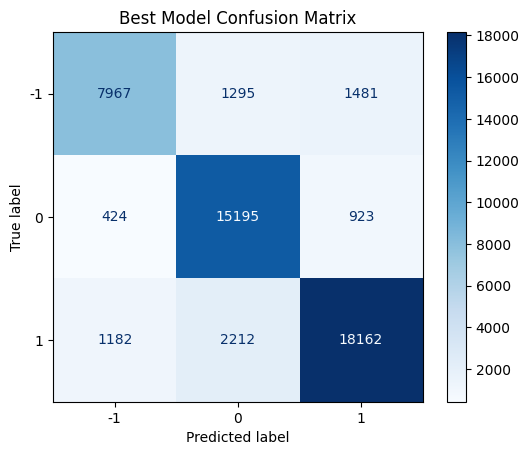

In [131]:
cm_best_model_values = confusion_matrix(y_true, y_pred)
cm_best_model = ConfusionMatrixDisplay.from_predictions(
    y_true, 
    y_pred,
    cmap='Blues',
    display_labels=[-1, 0, 1]
)
plt.title('Best Model Confusion Matrix')
plt.show()

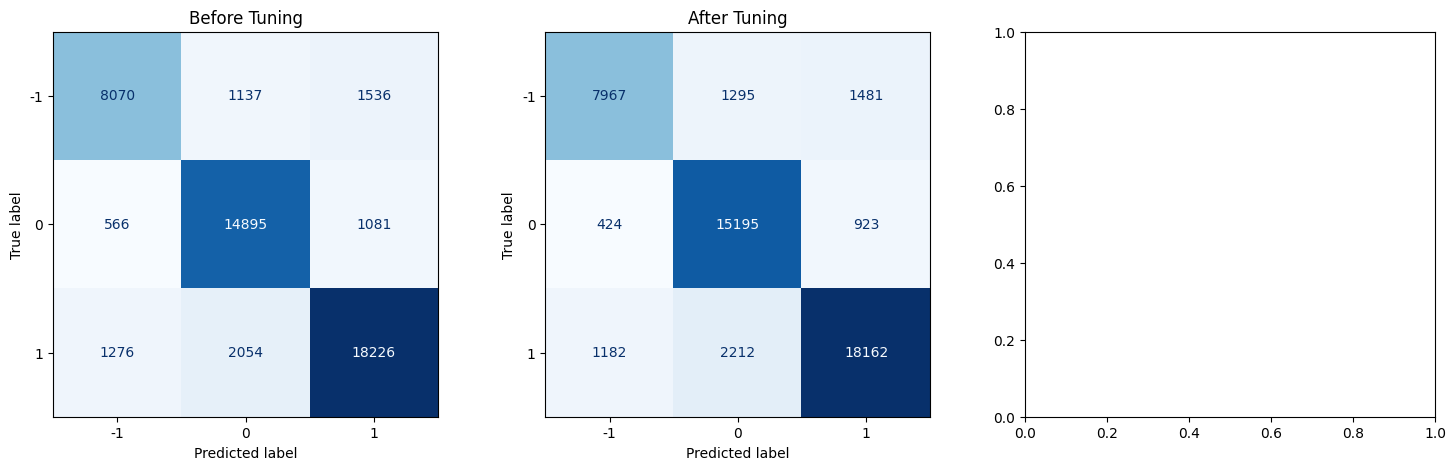

In [132]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# confusion matrix before tuning
disp1 = ConfusionMatrixDisplay(cm_baseline_values, display_labels=[-1, 0, 1])
disp1.plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title('Before Tuning')

# confusion matrix after tuning
disp2 = ConfusionMatrixDisplay(cm_best_model_values, display_labels=[-1, 0, 1])
disp2.plot(ax=axes[1], cmap='Blues', colorbar=False)
axes[1].set_title('After Tuning')

cm_diff = cm_best_model_values - cm_baseline_values 

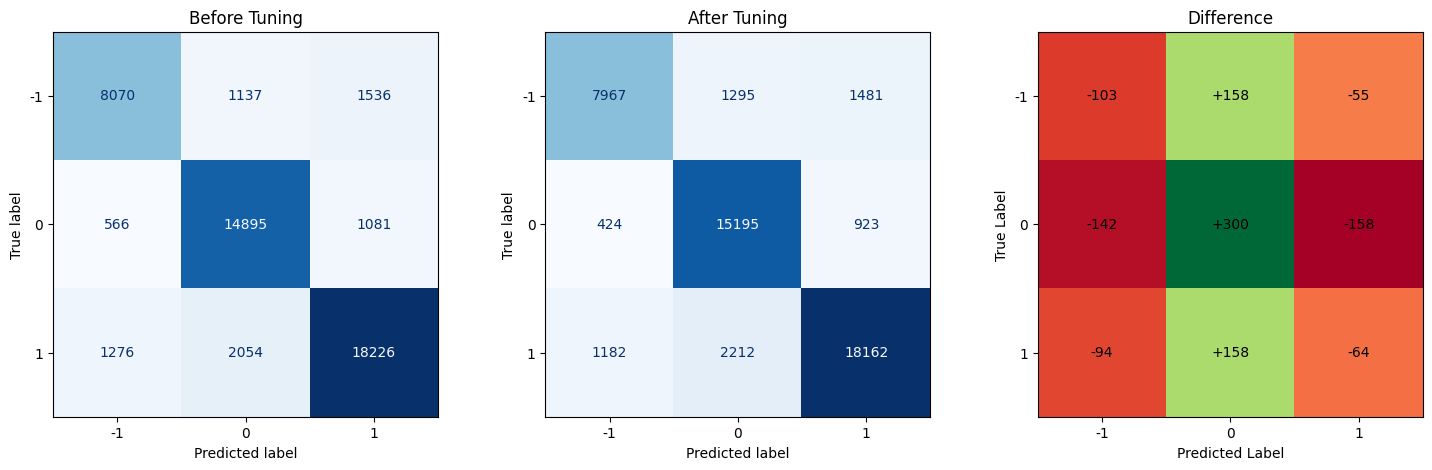

In [133]:
# difference matrix
im = axes[2].imshow(cm_diff, cmap='RdYlGn')

for i in range(cm_diff.shape[0]):
    for j in range(cm_diff.shape[1]):
        value = cm_diff[i, j]
        label = f'+{value}' if value > 0 else str(value)
        color = 'black'
        axes[2].text(j, i, label, ha='center', va='center', color=color)

axes[2].set_xticks([0, 1, 2])
axes[2].set_yticks([0, 1, 2])
axes[2].set_xticklabels([-1, 0, 1])
axes[2].set_yticklabels([-1, 0, 1])
axes[2].set_xlabel('Predicted Label')
axes[2].set_ylabel('True Label')
axes[2].set_title('Difference')

display(fig)

In [134]:
print("Summary of Changes:")
print(f"Before Tuning - Total True Positive: {np.trace(cm_baseline_values)} / {cm_baseline_values.sum()}")
print(f"After Tuning  - Total True Positive: {np.trace(cm_best_model_values)} / {cm_best_model_values.sum()}")
print(f"Improvement: {np.trace(cm_best_model_values) - np.trace(cm_baseline_values):+d} correct predictions")

labels = [-1, 0, 1]
print("\nPer-class diagonal change (correct predictions):")
for i, label in enumerate(labels):
    change = cm_diff[i, i]
    print(f"  Class {label:2d}: {change:+d}")

Summary of Changes:
Before Tuning - Total True Positive: 41191 / 48841
After Tuning  - Total True Positive: 41324 / 48841
Improvement: +133 correct predictions

Per-class diagonal change (correct predictions):
  Class -1: -103
  Class  0: +300
  Class  1: -64


Although there is an increase in the performance of the model, it seems that the `best_model` had a tendency to predict more neutral classifiers over true positive labels.

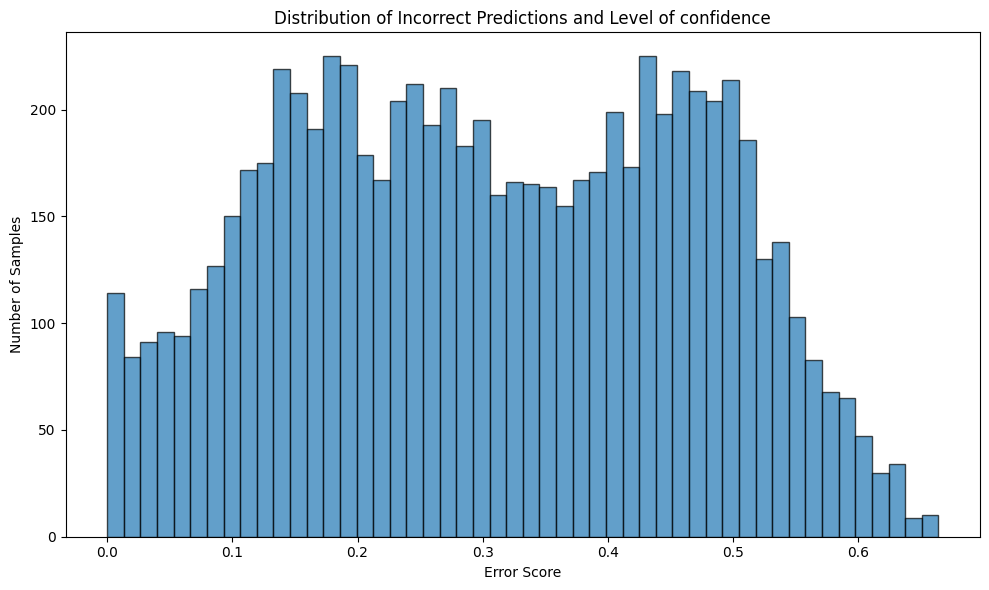

Total incorrect predictions: 7517/48841
Mean error score: 0.3067


In [135]:
confidence = y_prob.max(axis=1)

incorrect_mask = y_pred != y_test.values
incorrect_confidence = confidence[incorrect_mask]

plt.figure(figsize=(10, 6))
plt.hist(1 - incorrect_confidence, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Error Score')
plt.ylabel('Number of Samples')
plt.title('Distribution of Incorrect Predictions and Level of confidence')
plt.tight_layout()
plt.show()

print(f"Total incorrect predictions: {incorrect_mask.sum()}/{len(y_pred)}")
print(f"Mean error score: {(1 - incorrect_confidence).mean():.4f}")

Most of the errors here have a low error score (and low mean error score) indicating high confidence for the wrong class prediction, possible overfitting (ill edit)

## **Error Analysis and Model Tuning**

As previously mentioned in **`data.ipynb`** the data is imbalanced between sentiment classes, the majority class is `1` (positive), followed by `0` (neutral) and a minority class of `-1`(negative). The preformance of the model reflects this imbalance, where the majority class `1` performs the best while the minority class `-1` performs the worse on the test set even despite optimizing model hyperparamters. It can be assumed that there exists a relationship, let us try training the data on a balanced training set.

In **`data.ipynb`** a balanced test set exists and are stored as variables `Xb_train` and `yb_train`.

In [136]:
best_model.fit(Xb_train, yb_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",0.3
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [137]:
best_model.score(X_test, y_test)

0.8678159742839008

In [138]:
y_true = y_test
y_pred = best_model.predict(X_test)

In [139]:
report_classification_performance(best_model, y_pred, y_test, show_cm=False, digits=4)

Accuracy: 0.8678159742839008

Classification Report:

              precision    recall  f1-score   support

          -1     0.8064    0.8692    0.8366     10743
           0     0.8351    0.9301    0.8801     16542
           1     0.9376    0.8193    0.8745     21556

    accuracy                         0.8678     48841
   macro avg     0.8597    0.8729    0.8637     48841
weighted avg     0.8740    0.8678    0.8680     48841



array([ 0,  0,  0, ...,  1, -1,  0], shape=(48841,))

In [140]:
y_prob = best_model.predict_proba(X_test)
print(f"{log_loss(y_true, y_prob):.4f}")

0.4093


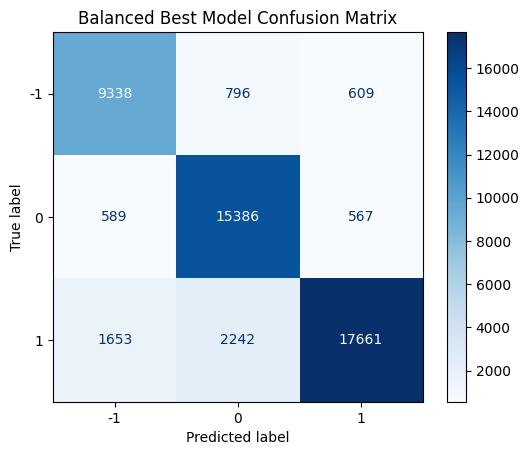

In [141]:
cm_balanced_best_model_values = confusion_matrix(y_true, y_pred)
cm_balanced_best_model = ConfusionMatrixDisplay.from_predictions(
    y_true, 
    y_pred,
    cmap='Blues',
    display_labels=[-1, 0, 1]
)
plt.title('Balanced Best Model Confusion Matrix')
plt.show()

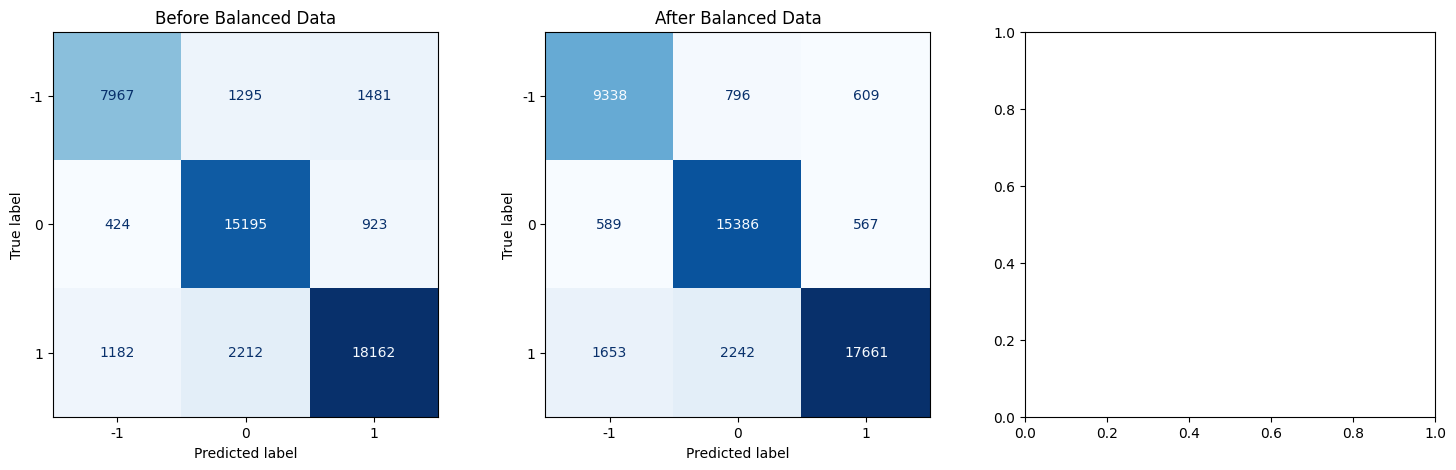

In [142]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# confusion matrix before balancing
disp1 = ConfusionMatrixDisplay(cm_best_model_values, display_labels=[-1, 0, 1])
disp1.plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title('Before Balanced Data')

# confusion matrix after tuning
disp2 = ConfusionMatrixDisplay(cm_balanced_best_model_values, display_labels=[-1, 0, 1])
disp2.plot(ax=axes[1], cmap='Blues', colorbar=False)
axes[1].set_title('After Balanced Data')

cm_diff = cm_balanced_best_model_values - cm_best_model_values

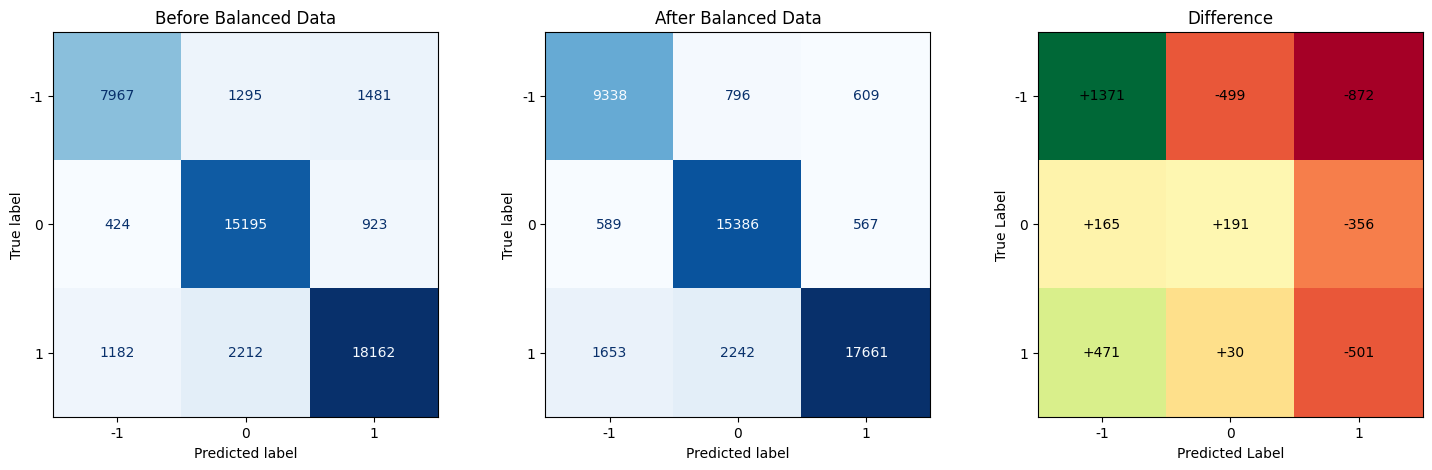

In [143]:
# difference matrix
im = axes[2].imshow(cm_diff, cmap='RdYlGn')

for i in range(cm_diff.shape[0]):
    for j in range(cm_diff.shape[1]):
        value = cm_diff[i, j]
        label = f'+{value}' if value > 0 else str(value)
        color = 'black'
        axes[2].text(j, i, label, ha='center', va='center', color=color)

axes[2].set_xticks([0, 1, 2])
axes[2].set_yticks([0, 1, 2])
axes[2].set_xticklabels([-1, 0, 1])
axes[2].set_yticklabels([-1, 0, 1])
axes[2].set_xlabel('Predicted Label')
axes[2].set_ylabel('True Label')
axes[2].set_title('Difference')

display(fig)

In [146]:
print("Summary of Changes:")
print(f"Before Balanced Set - Total True Positive: {np.trace(cm_best_model_values)} / {cm_best_model_values.sum()}")
print(f"After Balanced set  - Total True Positive: {np.trace(cm_balanced_best_model_values)} / {cm_balanced_best_model_values.sum()}")
print(f"Improvement: {np.trace(cm_balanced_best_model_values) - np.trace(cm_best_model_values):+d} correct predictions")

labels = [-1, 0, 1]
print("\nPer-class diagonal change (correct predictions):")
for i, label in enumerate(labels):
    change = cm_diff[i, i]
    print(f"  Class {label:2d}: {change:+d}")

Summary of Changes:
Before Balanced Set - Total True Positive: 41324 / 48841
After Balanced set  - Total True Positive: 42385 / 48841
Improvement: +1061 correct predictions

Per-class diagonal change (correct predictions):
  Class -1: +1371
  Class  0: +191
  Class  1: -501


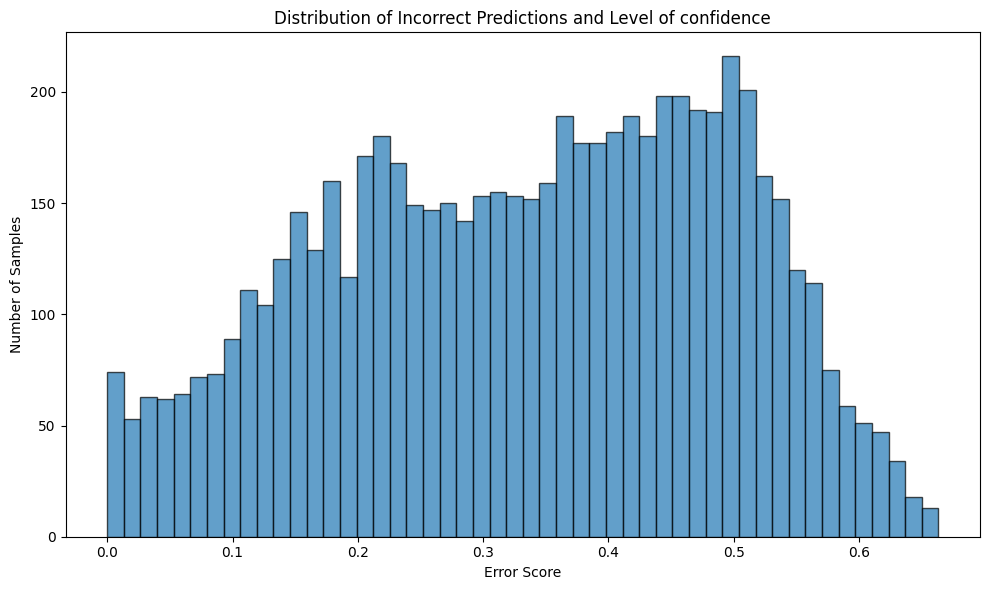

Total incorrect predictions: 6456/48841
Mean error score: 0.337


In [145]:
confidence = y_prob.max(axis=1)

incorrect_mask = y_pred != y_test.values
incorrect_confidence = confidence[incorrect_mask]

plt.figure(figsize=(10, 6))
plt.hist(1 - incorrect_confidence, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Error Score')
plt.ylabel('Number of Samples')
plt.title('Distribution of Incorrect Predictions and Level of confidence')
plt.tight_layout()
plt.show()

print(f"Total incorrect predictions: {incorrect_mask.sum()}/{len(y_pred)}")
print(f"Mean error score: {(1 - incorrect_confidence).mean():.3f}")